## Introduction

This project is a clustering model and random forest model joined together to predict the authors of texts based primarily on the text data. Numerous clustering techniques are tried and assessed on accuracy and ability to separate authors into distinct clusters.\n
The data is taken from https://www.kaggle.com/tenacious84/4000-short-stories-scored-for-vad-doc-vectors. It is cleaned down to a smaller subset of 638 works with stopwords removed and 27 authors. The final model is a k-means clustering algorithm and random forest model, and has about 32% accuracy.

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.cluster import (KMeans, MeanShift, estimate_bandwidth, SpectralClustering,
                             AffinityPropagation)

warnings.filterwarnings(action ='ignore', module='sklearn')

First, pick a set of texts. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related.

In [5]:
stories = pd.read_csv('data/stories.csv')

In [6]:
df = stories[['length', 'title', 'author', 'story']]
# numerous outliers that are hardly 'short' stories, removing
df = df[df.length < 16000]
# cutting down to 1000 authors
df = df.sample(n = 1000, random_state = 5)
df.head()

length                         title                  author  \
1428    7772  Peter Goldthwaite's Treasure     Nathaniel Hawthorne   
3353    8602               Queen of Spades       Edward Payson Roe   
2154    4786               In The Presence         Rudyard Kipling   
592     6574         To Whom This May Come          Edward Bellamy   
3396    3557                  The Sea Fogs  Robert Louis Stevenson   

                                                  story  
1428  "And so, Peter, you won't even consider of the...  
3353  "Mother," remarked Farmer Banning, discontente...  
2154  (1912)\n\n'So the matter,' the Regimental Chap...  
592   IT is now about a year since I took passage at...  
3396   A sheeted spectre white and tall, The cold mi...

In [14]:
for author in df.author.unique():
    print(len(df[df.author == author]), author)

18 Nathaniel Hawthorne
39 Rudyard Kipling
52 Guy De Maupassant
20 Ambrose Bierce
19 Henry Van Dyke
13 Honore De Balzac
13 Arthur Quiller Couch
12 Hg Wells
45 Jack London
64 O Henry
14 Edgar Allan Poe
17 William Dean Howells
21 Mary E Wilkins Freeman
12 Harriet Beecher Stowe
12 P G Wodehouse
44 Aesop
33 W W Jacobs
46 Mark Twain
13 Charles Dickens
10 Hans Christian Andersen
18 Bret Harte
13 Ts Arthur
11 Henry Lawson
13 H P Lovecraft
11 Frank Stockton
37 Hh Munro Saki
18 Kate Chopin


In [15]:
# dropping authors with fewer than 10 works
for author in df.author.unique():
    if len(df[df.author == author]) < 10:
           df.drop(df[df.author == author].index, inplace = True)

In [16]:
for author in df.author.unique():
    print(len(df[df.author == author]), author)

18 Nathaniel Hawthorne
39 Rudyard Kipling
52 Guy De Maupassant
20 Ambrose Bierce
19 Henry Van Dyke
13 Honore De Balzac
13 Arthur Quiller Couch
12 Hg Wells
45 Jack London
64 O Henry
14 Edgar Allan Poe
17 William Dean Howells
21 Mary E Wilkins Freeman
12 Harriet Beecher Stowe
12 P G Wodehouse
44 Aesop
33 W W Jacobs
46 Mark Twain
13 Charles Dickens
10 Hans Christian Andersen
18 Bret Harte
13 Ts Arthur
11 Henry Lawson
13 H P Lovecraft
11 Frank Stockton
37 Hh Munro Saki
18 Kate Chopin


In [17]:
df.reset_index(inplace = True)

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop = set(stopwords.words('english'))
# The first iteration with just stopwords gave me clusters featuring these words
# These clusters were incredibly unhelpful, so we are removing these words
more_stopwords = ['jerry', 'thomas', 'conrad', 'maida', 'ses', 'im',
                  'ad', 'is', 'wot', 'arter', 'babette', 'johnsy',
                  'williams', 'molly', 'james', 'nainaine', 'indians',
                  'charley', 'joe', 'uri', 'billy', 'keogh', 'loretta',
                  'leeson', 'abe', 'johnny', 'bashford', 'parker',
                  'miss', 'hemingway', 'wal', 'says', 'de', 'huldy',
                  'tom', 'em', 'dat', 'av', 'sez', 'ut', 'wid',
                  'mulvaney', 'ortheris', 'whin', 'dearsley', 'dinah',
                  'shadd', 'em', 'll', 'one', '000', 'maggie', 'pomfrey',
                  'diantha', 'kidd', 'watkins', 'peters', 'hooper',
                  'simpson', 'buffin', 'oakhurst', 'skipper', 'mate',
                  'said', 'deck', 'll', 'bill', 'ted', 'agravaine',
                  'drusilla', 'endicott', 'delia', 'travers', '_amigo_',
                  'latimer', 'clarence', 'merriam', 'mcramsey',
                  'portillone', 'caliph', 'dan', 'the', 'and', 'of',
                  'to', 'in', 'he', 'was', 'it', 'that', 'his',
                  'watkins', 'gayerson', 'annodomini', 'clemens',
                  'forsyth', 'retford', 'rastall', 'octavia', 'mccoy',
                  'teddy', 'phillips', 'plunkett', 'hauksbee', 'thompson',
                  'crefton', 'scratchard', 'kertarkut', 'pillamon',
                  'louisa', 'heffelbower', 'octavian', 'larut', 'ranse',
                  'constance', 'desiree', 'arnold', 'oreille', 'sommers',
                  'er', 'arter', 'nancy', 'chang', 'lou', 'eng', 'cork',
                  'rooney', 'lewminster', 'thackenbury', 'esther',
                  'eleanor', 'wal', 'miry', 'pepton', 'alferd', 'ernest',
                  'asenath', 'mcphee', 'musides', 'pyecraft', 'kalos',
                  'dempsey', 'jakin', 'endicott', 'sullivan', 'shaynor',
                  'dolly', 'bruno', 'huldy', 'nafferton', 'oan',
                  'pinecoffin', 'eggelby', 'oakhurst', 'grégoire',
                  'raggles', 'dey', 'davis', 'wotton', 'ada', 'danny',
                  'skelmersdale', 'moxon', 'attray', 'falloner', 'aubyn',
                  'ronnie', 'tuk', 'tukey', 'boyle', 'cantire', 'regula',
                  'jacques', 'irene', 'berthine', 'santeze', 'luella',
                  'roderick', 'antaeus', 'perkins', 'katy', 'chicot', 
                  'peggy', 'pierrot', 'lefevre', 'viola', 'peters',
                  'loretta', 'ogden', 'emmeline', 'churchill', 'barbara',
                  'lester', 'elinor', 'masterton', 'bondell', 'scudder',
                  'gwenda', 'martha', 'wressley', 'rollo', 'fagg',
                  'gibbs', 'kidd', 'bates', 'murkison', 'tarleton',
                  'rattler', 'ferguson', 'drusilla', 'cooper', 'lawson',
                  'quabarl', 'caroline', 'dearsley', 'charley', 'kent',
                  'alec', 'maggie', 'kempelen', 'von', 'grafin',
                  'stossen', 'lispeth', 'il', 'leeson', 'solly', 'sally',
                  'reggie', 'riley', 'connor', 'luc', 'vanessa',
                  'adrian', 'jimmy', 'clyde', 'mamzelle', 'fleurette',
                  'aurlie', 'jonas', 'marin', 'jenny', 'wilfrid',
                  'loring', 'hercules', 'turpin', 'egbert', 'anne',
                  'edwin', 'williams', 'aiken', 'wi', 'sprague',
                  'framton', 'warren', 'harding', 'ramon', 'gallegos']
stop = stop.union(more_stopwords)
df['story_filter'] = df.story

# removing the stopwords from the stories
for i in range(len(df)):
    tokens = word_tokenize(df.story[i].lower())
    df.story_filter[i] = [i for i in tokens if i not in stop]
    df.story_filter[i] = ' '.join(df.story_filter[i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
import nltk
from collections import Counter

# creating part of speech frequency columns
verbs = []
adjectives = []
adverbs = []
nouns = []
commas = []
periods = []
quotes = []
adverbs = []

for i in range(len(df.story_filter)):
    tokenized = word_tokenize(df.story[i])
    tagged_story = nltk.pos_tag(tokenized)
    tag_fd = Counter(tag for word, tag in tagged_story)
    # taking the counts of each part of speech (ie JJ for adjectives)
    adjectives.append(tag_fd['JJ'])
    nouns.append(tag_fd['NN'] + tag_fd['NNS'])
    commas.append(tag_fd[','])
    periods.append(tag_fd['.'])
    quotes.append(tag_fd['``'])
    verbs.append(tag_fd['VBD'] + tag_fd['VBG'] + tag_fd['VBP']
                 + tag_fd['VBZ'] + tag_fd['VBN'] + tag_fd['VB'])
    adverbs.append(tag_fd['RB'])
    
df['verbs'] = verbs
df['adjectives'] = adjectives
df['adverbs'] = adverbs
df['nouns'] = nouns
df['commas'] = commas
df['periods'] = periods
df['quotes'] = quotes

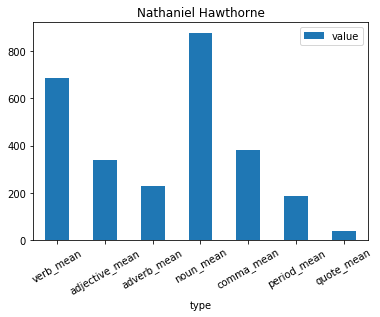

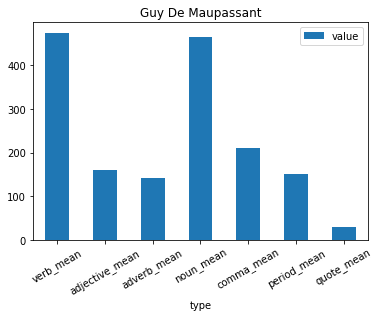

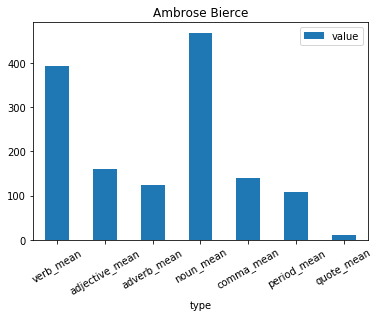

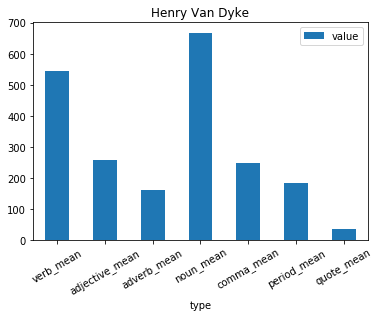

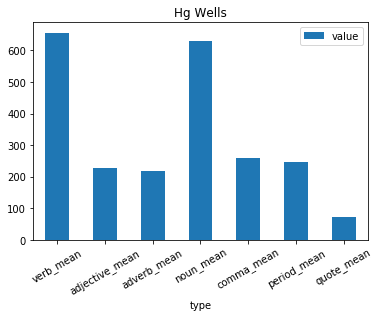

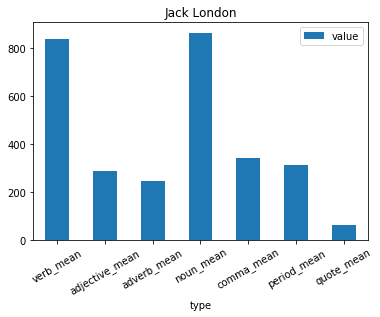

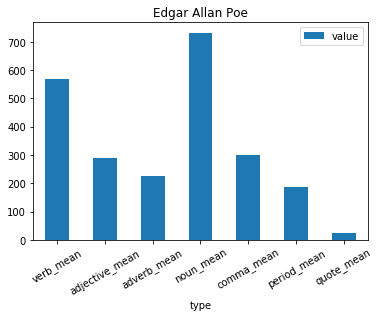

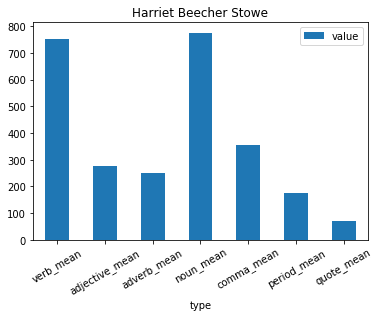

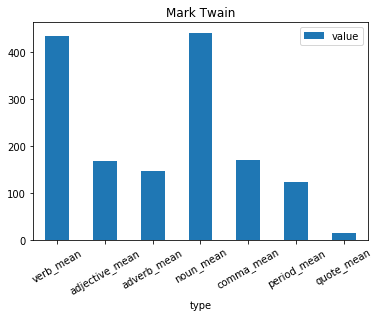

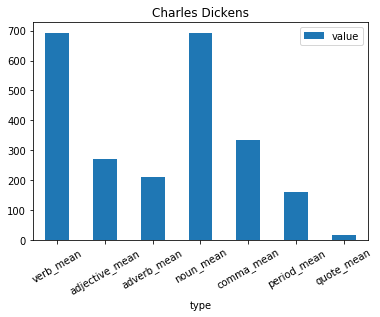

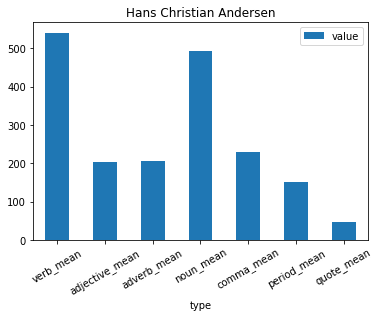

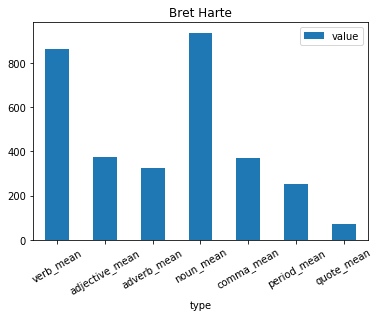

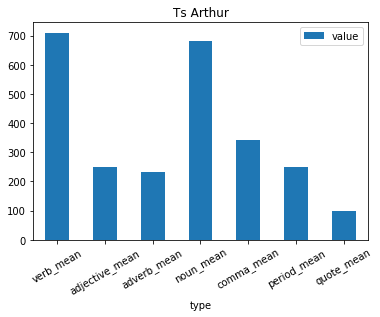

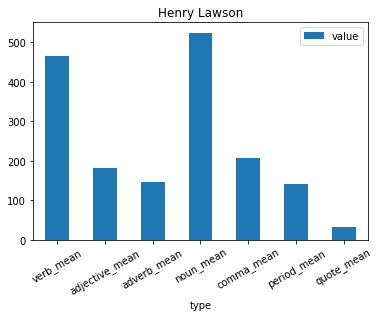

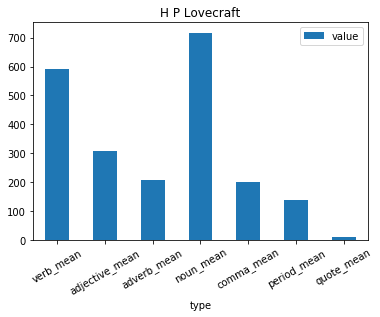

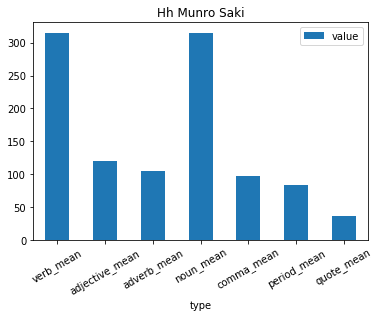

In [62]:
# barplots for each author's part of speech count
for author in df.author.unique():
    author_df = pd.DataFrame({'type':['verb_mean', 'adjective_mean', 'adverb_mean',
                                      'noun_mean', 'comma_mean', 'period_mean', 'quote_mean'],
                             'value':[df[df.author == author].verbs.mean(),
                                     df[df.author == author].adjectives.mean(),
                                     df[df.author == author].adverbs.mean(),
                                     df[df.author == author].nouns.mean(),
                                     df[df.author == author].commas.mean(),
                                     df[df.author == author].periods.mean(),
                                     df[df.author == author].quotes.mean()]})
    
    author_df.plot.bar(x = 'type', y = 'value', title = author, rot = 30)

The most difference between authors is in the quantity of verbs, adjectives, and periods. There is probably enough difference here to add value to a model.

In [19]:
df.story

0      "And so, Peter, you won't even consider of the...
1      (1912)\n\n'So the matter,' the Regimental Chap...
2      It was a wedding procession that was coming al...
3      'Are you serious? -- do you really believe tha...
4      The Commandant of the Marine Hospital was at h...
                             ...                        
633    The young man came into the club-house. There ...
634    "There is a wild beast in your woods," said th...
635    Half the time the wind blew a gale, and Smoke ...
636    When a man journeys into a far country, he mus...
637    San Francisco Bay is so large that often its s...
Name: story, Length: 638, dtype: object

In [20]:
df.story_filter

0      `` , peter , wo n't even consider business ? '...
1      ( 1912 ) 'so matter , ' regimental chaplain co...
2      wedding procession coming along road tall tree...
3      'are serious ? -- really believe machine think...
4      commandant marine hospital desk , working hard...
                             ...                        
633    young man came club-house . frown usually chee...
634    `` wild beast woods , '' artist cunningham , d...
635    half time wind blew gale , smoke bellew stagge...
636    man journeys far country , must prepared forge...
637    san francisco bay large often storms disastrou...
Name: story_filter, Length: 638, dtype: object

author: Nathaniel Hawthorne


author: Rudyard Kipling


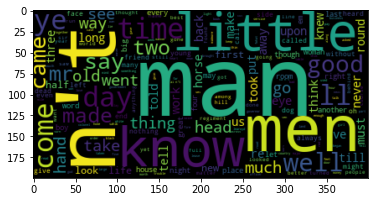

author: Guy De Maupassant


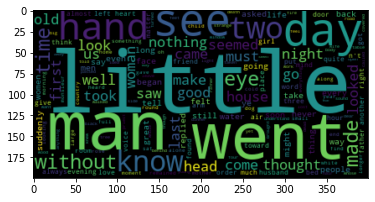

author: Ambrose Bierce


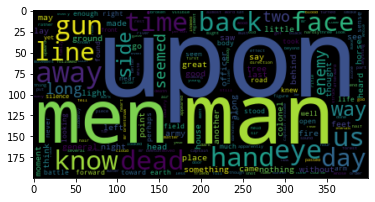

author: Henry Van Dyke


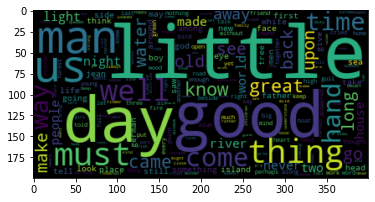

author: Honore De Balzac


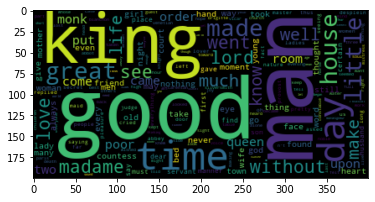

author: Arthur Quiller Couch


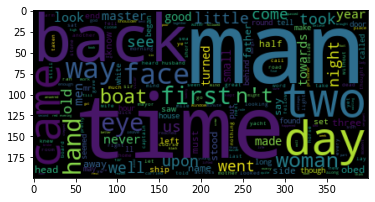

author: Hg Wells


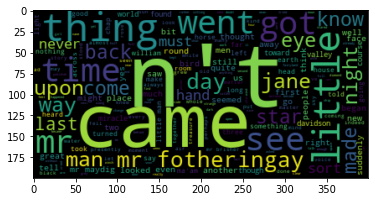

author: Jack London


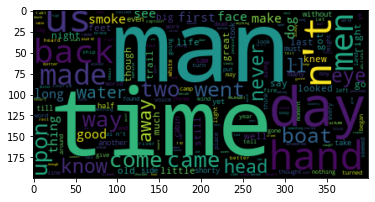

author: O Henry


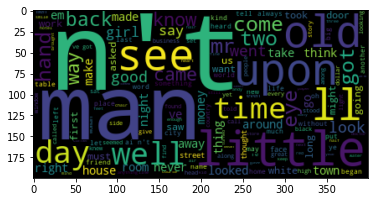

author: Edgar Allan Poe


author: William Dean Howells


author: Mary E Wilkins Freeman


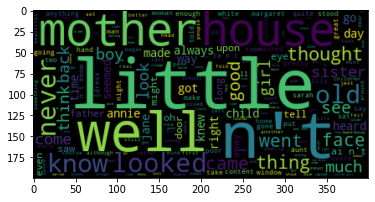

author: Harriet Beecher Stowe


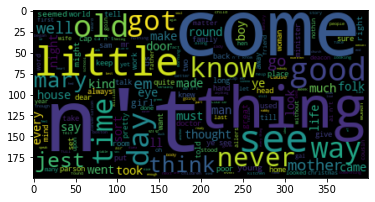

author: P G Wodehouse


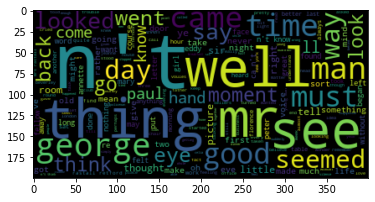

author: Aesop


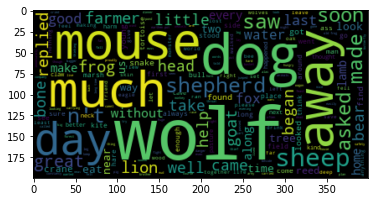

author: W W Jacobs


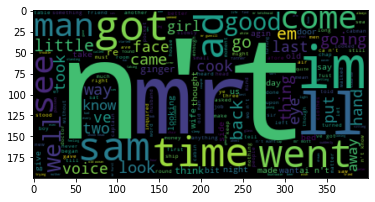

author: Mark Twain


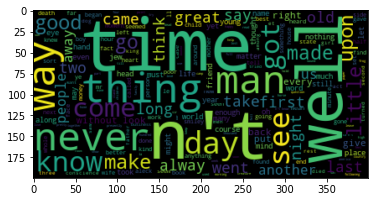

author: Charles Dickens


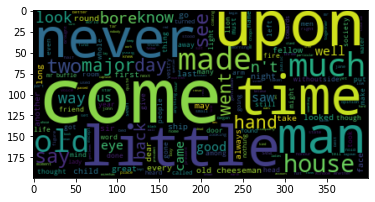

author: Hans Christian Andersen


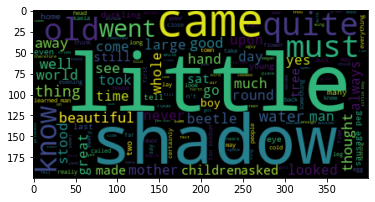

author: Bret Harte


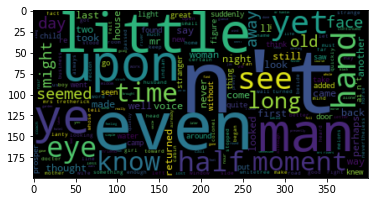

author: Ts Arthur


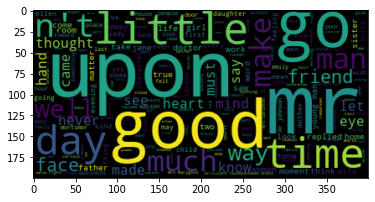

author: Henry Lawson


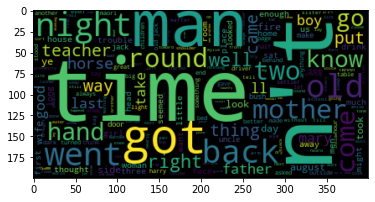

author: H P Lovecraft


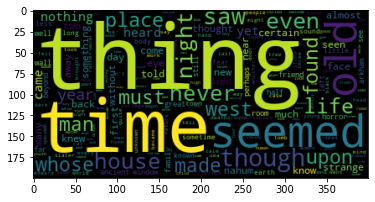

author: Frank Stockton


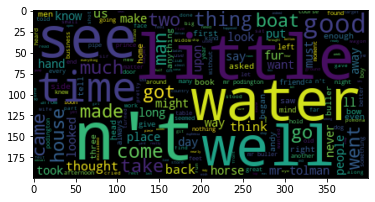

author: Hh Munro Saki


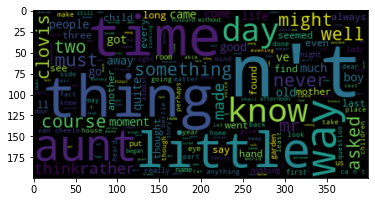

author: Kate Chopin


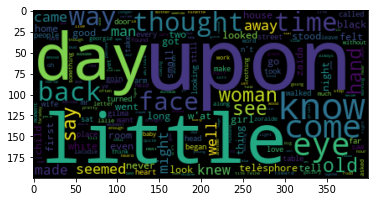

In [63]:
from wordcloud import WordCloud
# take all works that are written by the same author and make a word cloud of each
for author in df.author.unique():
    # filter for texts written by the same author
    text = df[df.author == author].story_filter
    wordcloud = WordCloud().generate(str(text.values))
    # display the word cloud
    print('author: %s' % author)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

The similarity of common word counts is going to be a major problem while clustering. Some authors use markedly different words, but almost all have the same word counts for the most common words.

Reserve 25% of your corpus as a test set.

In [68]:
# Splitting data into train and test
X, X_test = train_test_split(df, random_state = 5)
y = X.author
y_test = X_test.author

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vec = vectorizer.fit(X.story_filter)
X_vec = vec.transform(X.story_filter)
# Many authors apparently have the same writing style, as a number of clusters are redundant
# 16 lowered the number of redundant clusters, measured by the keywords from the cell below
km = KMeans(n_clusters = 16,
           max_iter = 150).fit(X_vec)

In [97]:
# Silhouette score to evaluate our clusters
from sklearn import metrics

metrics.silhouette_score(X_vec, km.labels_)

0.004351421868732996

It looks like our cluster assignments are nearly random. This does not bode well for the model. That being said, silhouette scores do not scale well, and our features are somewhat numerous.

In [13]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(16):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 monsieur
 madame
 would
 man
 mme
 woman
 francs
 saint
 little
 went
Cluster 1:
 twain
 upon
 wilson
 mr
 discovery
 kissam
 gold
 crimson
 journal
 curtains
Cluster 2:
 andy
 em
 fur
 sullivan
 git
 trotter
 ll
 000
 seagull
 bramble
Cluster 3:
 man
 would
 captain
 could
 like
 little
 time
 boat
 two
 ship
Cluster 4:
 would
 know
 well
 old
 man
 could
 like
 got
 see
 ll
Cluster 5:
 old
 little
 boy
 man
 mother
 could
 would
 tree
 like
 children
Cluster 6:
 upon
 man
 could
 like
 would
 old
 little
 time
 great
 us
Cluster 7:
 jest
 sam
 ye
 prosper
 parson
 cap
 see
 mis
 em
 lon
Cluster 8:
 mrs
 would
 clovis
 peter
 little
 ve
 know
 man
 mother
 pig
Cluster 9:
 im
 ad
 is
 ave
 em
 fust
 agin
 sam
 cook
 silas
Cluster 10:
 jane
 walter
 annie
 wilton
 carew
 helen
 charles
 painter
 benny
 ma
Cluster 11:
 doctor
 farmer
 man
 little
 went
 could
 connor
 would
 ll
 back
Cluster 12:
 mr
 mrs
 ll
 boatswain
 mott
 veil
 keating
 hinkle
 hurs

In [14]:
# affintiy-propagation modeling
ap = AffinityPropagation().fit(X_vec)

# Take each author, run their works through the predict function, count the number of works
# in each cluster
for author in X.author.unique():
    work = X[X.author == author].story_filter
    # tf-idf vector transformation
    XX = vec.transform(work)
    # affinity propagation prediction
    work_predict = ap.predict(XX)
    print(author)
    print('total works: %d' % len(X[X.author == author]))
    print(Counter(work_predict))

Honore De Balzac
total works: 11
Counter({0: 5, 2: 3, 56: 1, 15: 1, 5: 1})
Guy De Maupassant
total works: 43
Counter({56: 19, 54: 7, 68: 6, 6: 2, 37: 2, 66: 2, 2: 1, 3: 1, 51: 1, 32: 1, 41: 1})
Mary E Wilkins Freeman
total works: 14
Counter({37: 3, 16: 2, 20: 2, 18: 1, 8: 1, 71: 1, 5: 1, 31: 1, 48: 1, 70: 1})
O Henry
total works: 51
Counter({1: 5, 17: 5, 28: 5, 55: 5, 71: 4, 32: 3, 34: 2, 48: 2, 22: 2, 21: 2, 53: 2, 66: 2, 52: 2, 3: 1, 57: 1, 31: 1, 12: 1, 25: 1, 45: 1, 27: 1, 24: 1, 16: 1, 41: 1})
H P Lovecraft
total works: 9
Counter({8: 3, 56: 2, 51: 2, 46: 1, 48: 1})
Mark Twain
total works: 36
Counter({71: 11, 37: 3, 48: 3, 5: 2, 64: 2, 3: 2, 23: 2, 21: 2, 67: 1, 17: 1, 50: 1, 11: 1, 29: 1, 65: 1, 56: 1, 16: 1, 4: 1})
Nathaniel Hawthorne
total works: 15
Counter({21: 4, 48: 2, 26: 2, 25: 1, 33: 1, 37: 1, 41: 1, 13: 1, 17: 1, 3: 1})
Ts Arthur
total works: 9
Counter({17: 3, 3: 2, 16: 2, 18: 1, 21: 1})
Kate Chopin
total works: 12
Counter({37: 3, 3: 2, 48: 2, 56: 1, 71: 1, 36: 1, 16: 1, 

In [15]:
# converting to a dense array
X_vec_dense = X_vec.toarray()
#estimating bandwidth
bandwidth = estimate_bandwidth(X_vec_dense, n_jobs = -1)
# mean-shift modeling
ms = MeanShift(bandwidth = bandwidth, n_jobs = -1).fit(X_vec_dense)

for author in X.author.unique():
    work = X[X.author == author].story_filter
    # tf-idf vector transformation
    XX = vec.transform(work)
    # mean-shift prediction
    work_predict = ms.predict(XX)
    print(author)
    print('total works: %d' % len(X[X.author == author]))
    print(Counter(work_predict))

Honore De Balzac
total works: 11
Counter({0: 11})
Guy De Maupassant
total works: 43
Counter({0: 43})
Mary E Wilkins Freeman
total works: 14
Counter({0: 14})
O Henry
total works: 51
Counter({0: 51})
H P Lovecraft
total works: 9
Counter({0: 9})
Mark Twain
total works: 36
Counter({0: 36})
Nathaniel Hawthorne
total works: 15
Counter({0: 15})
Ts Arthur
total works: 9
Counter({0: 9})
Kate Chopin
total works: 12
Counter({0: 12})
Bret Harte
total works: 15
Counter({0: 15})
Henry Lawson
total works: 8
Counter({0: 8})
Jack London
total works: 31
Counter({0: 31})
Hg Wells
total works: 5
Counter({0: 5})
Ambrose Bierce
total works: 15
Counter({0: 15})
W W Jacobs
total works: 25
Counter({0: 25})
Rudyard Kipling
total works: 29
Counter({0: 29})
Frank Stockton
total works: 9
Counter({0: 9})
Aesop
total works: 32
Counter({0: 32})
Edgar Allan Poe
total works: 8
Counter({0: 8})
William Dean Howells
total works: 13
Counter({0: 13})
Hh Munro Saki
total works: 30
Counter({0: 30})
Hans Christian Andersen
tot

In [16]:
# back to k means
from collections import Counter

for author in X.author.unique():
    work = X[X.author == author].story_filter
    # tf-idf vector transformation
    XX = vec.transform(work)
    # k-means predictions
    work_predict = km.predict(XX)
    print(author)
    print('total works: %d' % len(X[X.author == author]))
    print(Counter(work_predict))

Honore De Balzac
total works: 11
Counter({14: 5, 0: 4, 6: 1, 5: 1})
Guy De Maupassant
total works: 43
Counter({0: 23, 3: 8, 11: 4, 4: 3, 5: 3, 6: 2})
Mary E Wilkins Freeman
total works: 14
Counter({5: 3, 10: 2, 3: 2, 8: 2, 4: 2, 14: 1, 2: 1, 11: 1})
O Henry
total works: 51
Counter({11: 11, 3: 10, 6: 10, 4: 9, 12: 5, 2: 4, 8: 1, 5: 1})
H P Lovecraft
total works: 9
Counter({6: 7, 4: 2})
Mark Twain
total works: 36
Counter({3: 12, 4: 10, 6: 7, 14: 2, 11: 1, 1: 1, 2: 1, 7: 1, 8: 1})
Nathaniel Hawthorne
total works: 15
Counter({6: 8, 5: 3, 10: 1, 3: 1, 14: 1, 12: 1})
Ts Arthur
total works: 9
Counter({10: 2, 12: 2, 8: 2, 3: 1, 6: 1, 11: 1})
Kate Chopin
total works: 12
Counter({6: 5, 4: 2, 0: 2, 5: 1, 3: 1, 8: 1})
Bret Harte
total works: 15
Counter({6: 7, 4: 3, 3: 1, 12: 1, 11: 1, 7: 1, 8: 1})
Henry Lawson
total works: 8
Counter({4: 4, 11: 1, 8: 1, 6: 1, 5: 1})
Jack London
total works: 31
Counter({3: 16, 6: 6, 15: 3, 7: 2, 13: 1, 4: 1, 11: 1, 8: 1})
Hg Wells
total works: 5
Counter({12: 1, 3: 1

Looks like some authors are very successfully grouped into the same cluster, and some are unclusterable. The authors grouped into cluster eleven apparently have similar word frequencies. K-Means successfully groups at least half an author's works into the same cluster for 11 authors, which is pretty bad given there are 28 authors and many of the successfully clustered are 3s, 10s, and 13s.

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

In [73]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# using lda with 30 clusters
vec = vectorizer.fit(X.story_filter)
X_vec = vec.transform(X.story_filter)
lda = LDA(n_components = 30, n_jobs = -1).fit(X_vec)

In [18]:
#finding our key words for each cluster in the lda model
order_centroids = lda.components_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(30):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 capt
 goree
 telèsphore
 wilton
 madeline
 zaïda
 walter
 garvey
 abbe
 ash
Cluster 1:
 would
 man
 could
 like
 little
 old
 time
 mr
 mrs
 upon
Cluster 2:
 major
 officer
 valley
 york
 george
 duty
 island
 san
 basket
 soup
Cluster 3:
 brayle
 armand
 nainaine
 obituaries
 figs
 valmonde
 maman
 hara
 singh
 sahib
Cluster 4:
 connor
 mott
 hurst
 fox
 sarpint
 celeste
 atwood
 peach
 snuffed
 laundry
Cluster 5:
 prosper
 silas
 obed
 ead
 pore
 palmer
 madwell
 wilson
 eckert
 trever
Cluster 6:
 marsh
 hollis
 uk
 aurelia
 walen
 lundie
 commandant
 frogs
 era
 coleridge
Cluster 7:
 bean
 hitchcock
 bisara
 blair
 churton
 sausage
 peg
 pooree
 macglowrie
 adair
Cluster 8:
 aleck
 buffle
 matilda
 vera
 carew
 walter
 hampshire
 margaret
 lirriper
 tilbury
Cluster 9:
 chaplain
 shackles
 faraday
 cesaire
 halberdier
 angeline
 dennison
 mcmanus
 percival
 brunt
Cluster 10:
 king
 im
 master
 sam
 indeed
 andy
 gold
 prince
 indian
 mary
Cluster 11:
 sherman
 klugenstein

In [74]:
# transforming the data into cluster probabilities
clusters = lda.transform(X_vec)
clusters

array([[0.14380933, 0.00146727, 0.00146727, ..., 0.00146727, 0.00146727,
        0.00146727],
       [0.12213963, 0.00194523, 0.00194523, ..., 0.00194523, 0.00194523,
        0.00194523],
       [0.10936085, 0.00248048, 0.00248048, ..., 0.00248048, 0.00248048,
        0.00248048],
       ...,
       [0.12431244, 0.00150125, 0.00150125, ..., 0.00150125, 0.00150125,
        0.00150126],
       [0.13845492, 0.00277565, 0.00277565, ..., 0.00277565, 0.00277565,
        0.00277565],
       [0.1048194 , 0.00230908, 0.00230908, ..., 0.00230908, 0.00230908,
        0.00230908]])

In [76]:
# the cluster assignment for each book
for i in clusters:
    final_cluster = [np.argmax(i) for i in clusters] 

print(final_cluster)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 26, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 16, 6, 6, 6, 29, 26, 6, 0, 6, 6, 6, 6, 6, 26, 6, 6, 6, 25, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 14, 6, 6, 6, 26, 6, 6, 3, 11, 6, 1, 10, 14, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 26, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 26, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 3, 6, 6, 3, 6, 6, 6, 6, 14, 6, 6, 6, 26, 6, 1, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 0, 14, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 26, 6, 6, 25, 14, 26, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 3, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 10, 14, 6, 6, 6, 6, 6, 6, 6, 6, 3, 9, 0, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 12, 26, 6, 6, 6, 6, 26, 6, 6, 6, 6, 6, 6, 6, 6, 6, 26, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 25, 6, 6, 26, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 29, 9, 6, 14, 6, 6, 25, 19, 6, 6, 6, 6, 6, 6, 6

In [77]:
# putting the lda data in the dataframe and counting total works assigned to each cluster
# for each author
X['lda_cluster'] = final_cluster

for author in X.author.unique():
    print(author)
    print('total works: %d' % len(X[X.author == author]))
    print(Counter(X[X.author == author].lda_cluster))

Honore De Balzac
total works: 11
Counter({6: 9, 3: 2})
Guy De Maupassant
total works: 43
Counter({6: 41, 0: 1, 3: 1})
Mary E Wilkins Freeman
total works: 14
Counter({6: 13, 0: 1})
O Henry
total works: 51
Counter({6: 40, 0: 5, 3: 3, 25: 1, 26: 1, 14: 1})
H P Lovecraft
total works: 9
Counter({6: 8, 25: 1})
Mark Twain
total works: 36
Counter({6: 25, 26: 5, 0: 3, 25: 1, 9: 1, 3: 1})
Nathaniel Hawthorne
total works: 15
Counter({6: 13, 3: 2})
Ts Arthur
total works: 9
Counter({6: 9})
Kate Chopin
total works: 12
Counter({6: 10, 10: 1, 0: 1})
Bret Harte
total works: 15
Counter({6: 14, 26: 1})
Henry Lawson
total works: 8
Counter({6: 7, 26: 1})
Jack London
total works: 31
Counter({6: 28, 3: 2, 14: 1})
Hg Wells
total works: 5
Counter({6: 5})
Ambrose Bierce
total works: 15
Counter({6: 14, 26: 1})
W W Jacobs
total works: 25
Counter({6: 25})
Rudyard Kipling
total works: 29
Counter({6: 18, 0: 3, 14: 2, 25: 2, 29: 1, 1: 1, 3: 1, 5: 1})
Frank Stockton
total works: 9
Counter({6: 8, 19: 1})
Aesop
total wo

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Of all of these models, K Means is the only vaguely satisfactory attempt. The others simply fail to differentiate between the novels. Below we will return to K Means and assign it's cluster predictions for each work over the lda_cluster. Then we will use a Random Forest model to predict the authors of the training group.

In [78]:
# using the tf-idf vectorized X again using the already trained km to generate
# k means predictions
predicted = km.predict(X_vec)
# assigning this value over lda_cluster
X.lda_cluster = predicted

cluster 0


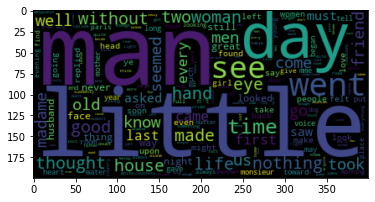

cluster 1


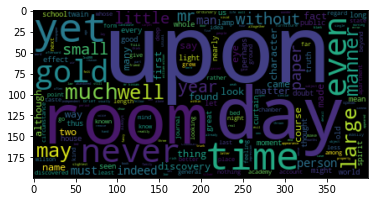

cluster 2


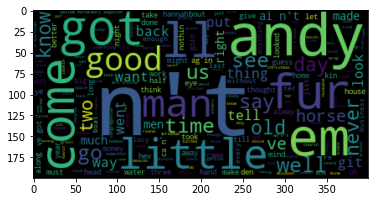

cluster 3


cluster 4


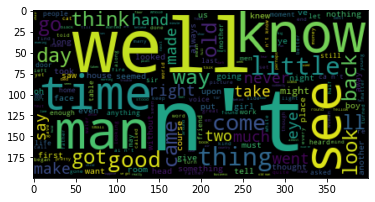

cluster 5


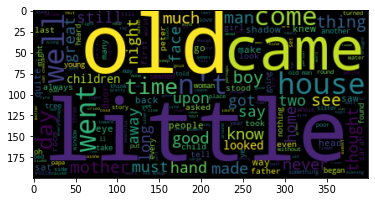

cluster 6


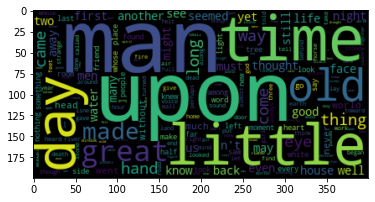

cluster 7


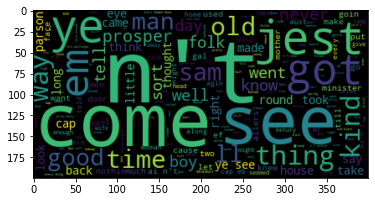

cluster 8


cluster 9


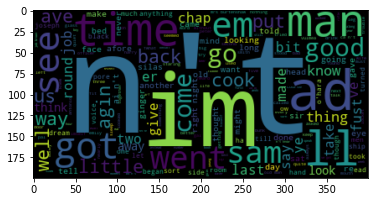

cluster 10


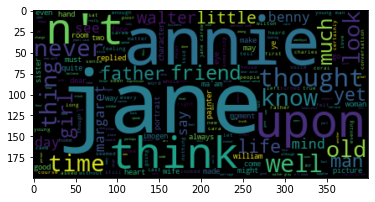

cluster 11


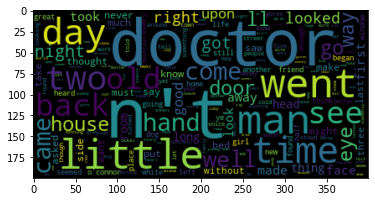

cluster 12


cluster 13


cluster 14


cluster 15


In [67]:
# take all works that are in the same cluster and lump them together
# then make a word cloud of each cluster
for i in range(16):
    # filter for texts in a cluster
    text = X[X.lda_cluster == i].story_filter
    wordcloud = WordCloud().generate(str(text.values))
    # display the word cloud
    print('cluster %d' % i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

Clearly 'man', 'little', 'time', 'eye', 'll', and 'n't' are candidates for addition to the stopwords list. We do see some clear differentiation for a few of the clusters. What we can also see is that because the vectorizer only goes for word frequency, all words end up being the features. If we apply human cognition to the problem, the features would likely be quite a lot smaller and would rely on uncommon words, mood of the text, setting, sentence length, and word combinations. It's small wonder the vectorizer and subsequent models are ineffective.

In [85]:
from sklearn.ensemble import RandomForestClassifier as RFC

rfc = RFC(n_estimators = 200,
         criterion = 'entropy',
         max_depth = 10,
         n_jobs = -1)
X_rfc = X.drop(columns = ['index', 'title', 'story', 'author', 'story_filter'])
rfc.fit(X_rfc, X.author)
cross_val = (cross_val_score(rfc, X_rfc, X.author, cv = 5))
cross_val_avg = sum(cross_val) / 5
print(cross_val, cross_val_avg)

[0.41904762 0.41584158 0.44791667 0.41758242 0.45882353] 0.4318423633733768


This looks bad, and it is, but the average is about 43% accuracy. Given that we have 27 authors, that means our model is doing something a little bit right. At this point, it might be performing better than an average human.

# Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is its performance consistent?

In [86]:
for author in X_test.author.unique():
    work = X_test[X_test.author == author].story_filter
    # tf-idf vector transformation
    XX = vec.transform(work)
    # k-means again
    work_predict = km.predict(XX)
    print(author)
    print('total works: %d' % len(X_test[X_test.author == author]))
    print(Counter(work_predict))

Harriet Beecher Stowe
total works: 3
Counter({10: 2, 8: 1})
Hans Christian Andersen
total works: 3
Counter({9: 3})
Mary E Wilkins Freeman
total works: 7
Counter({8: 6, 10: 1})
Nathaniel Hawthorne
total works: 3
Counter({9: 2, 3: 1})
Jack London
total works: 14
Counter({10: 5, 9: 4, 7: 4, 8: 1})
Aesop
total works: 12
Counter({9: 5, 11: 4, 5: 2, 10: 1})
Henry Van Dyke
total works: 4
Counter({9: 2, 10: 2})
Rudyard Kipling
total works: 10
Counter({3: 2, 6: 2, 10: 2, 9: 2, 4: 1, 8: 1})
Ts Arthur
total works: 4
Counter({4: 2, 10: 1, 3: 1})
Mark Twain
total works: 10
Counter({10: 8, 9: 2})
O Henry
total works: 13
Counter({10: 12, 8: 1})
Charles Dickens
total works: 5
Counter({3: 2, 10: 2, 9: 1})
Hh Munro Saki
total works: 7
Counter({10: 4, 4: 2, 9: 1})
Kate Chopin
total works: 6
Counter({8: 2, 10: 2, 9: 1, 0: 1})
P G Wodehouse
total works: 5
Counter({10: 4, 3: 1})
Hg Wells
total works: 7
Counter({9: 3, 10: 2, 14: 1, 3: 1})
William Dean Howells
total works: 4
Counter({10: 2, 9: 2})
Henry Lawso

The holdout is performing about the same as the training group, with authors being put into about the same clusters and the authors tending to have the same number of clusters to their name.

In [87]:
# vectorizing the test group
vec = TfidfVectorizer().fit(X.story_filter)
X_vec_test = vec.transform(X_test.story_filter)

# make clusters using k-means, assign clusters to a column in X_test
km_clusters = km.predict(X_vec_test)
X_test['km_clusters'] = km_clusters

# predict authors using random forest
X_rfc_test = X_test.drop(columns = ['index', 'title', 'story', 'author', 'story_filter'])
rfc_predictions = rfc.predict(X_rfc_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [88]:
# crosstab with actual values for the columns and predicted values for the index
pd.crosstab(rfc_predictions, X_test.author)

author                  Aesop  Ambrose Bierce  Arthur Quiller Couch  \
row_0                                                                 
Aesop                      10               0                     0   
Ambrose Bierce              0               1                     0   
Bret Harte                  0               0                     0   
Edgar Allan Poe             0               0                     0   
Frank Stockton              0               0                     0   
Guy De Maupassant           0               1                     1   
H P Lovecraft               0               1                     0   
Harriet Beecher Stowe       0               0                     0   
Henry Lawson                0               0                     0   
Henry Van Dyke              0               0                     0   
Hg Wells                    0               0                     0   
Hh Munro Saki               0               0                     0   
Jack London                 0               0                     0   
Kate Chopin                 2               1                     0   
Mark Twain                  0               1                     0   
Mary E Wilkins Freeman      0               0                     0   
Nathaniel Hawthorne         0               0                     0   
O Henry                     0               0                     0   
P G Wodehouse               0               0                     0   
Rudyard Kipling             0               0                     0   
Ts Arthur                   0               0                     0   
W W Jacobs                  0               0                     0   
William Dean Howells        0               0                     0   

author                  Bret Harte  Charles Dickens  Edgar Allan Poe  \
row_0                                                                  
Aesop                            0                0                0   
Ambrose Bierce                   0                0                0   
Bret Harte                       1                0                2   
Edgar Allan Poe                  0                1                0   
Frank Stockton                   0                0                0   
Guy De Maupassant                0                0                2   
H P Lovecraft                    0                0                0   
Harriet Beecher Stowe            0                0                0   
Henry Lawson                     0                0                0   
Henry Van Dyke                   0                0                0   
Hg Wells                         0                0                0   
Hh Munro Saki                    1                0                0   
Jack London                      0                2                0   
Kate Chopin                      0                0                0   
Mark Twain                       0                0                0   
Mary E Wilkins Freeman           0                0                0   
Nathaniel Hawthorne              1                0                1   
O Henry                          0                0                1   
P G Wodehouse                    0                0                0   
Rudyard Kipling                  0                2                0   
Ts Arthur                        0                0                0   
W W Jacobs                       0                0                0   
William Dean Howells             0                0                0   

author                  Frank Stockton  Guy De Maupassant  H P Lovecraft  \
row_0                                                                      
Aesop                                0                  0              0   
Ambrose Bierce                       0                  0              0   
Bret Harte                           0                  0              0   
Edgar Allan Poe                      0     

In [89]:
X_test.reset_index(inplace = True)

In [90]:
# making an accurate prediction counter
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == X_test.author[i]:
        acc += 1

# dividing correct predictions by total works
print(acc / len(rfc_predictions))

0.4125


The model is stable between the training set and the test set. We have 41% accuracy in the predictions for the test set, which is 2% below the accuracy for the training set.

If there is a divergence in the relative stability of your model and your clusters, delve into why.

K-means is more useful in smaller datasets. Our number of features is large, in the thousands, and scaling up above that would make the model slower and more prone to failure, especially when our features are likely not equal in variance and are not necessarily separable. Adding PCA would be a worthwhile measure, and using different metrics that are more separable would, however, probably prevent scaling from being an issue. In a large number of our clusters the same words were the most prominent, which would make K-means struggle. In addition, on a large number of authors and thus a large K, the data will be more likely to be inseparable. Again, while more issues would arise with size, these issues could be easily resolved by adding PCA and changing feature engineering to a couple of the features listed below, assuming they perform as well. In addition. minibatch k-means would be a good alternative for larger datasets.\
The random forest is less likely to have problems with scale, though it will be much slower.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

## Conclusion
The data was first cut down to authors with more than 9 works, then an extensive list of stopwords was removed from the stories. Part of speech frequency features were added. The data was then vectorized with a tf-idf vectorizer. After trying lda, spectral clustering, mean-shift, and affinity propagation on this vectorized data, K-means had the best performance separating authors into different clusters and limiting the number of clusters per author.\
Our model had some success. It had over 40% accuracy on the train and test sets, and there were 27 authors. Overall, of course, there is a lot to improve.\
K-means, part of speech frequency, and word vectorization alone are too weak to achieve any real use. As I noted earlier, human cognition would be a good model for future improvements. It is possible that not enough stop words were used, though the list that ended up being used here was already quite long. One potential step would be using the ngrams parameter in the tf-idf vectorizer, increasing the number of words per feature up to two or three for some features. Aspects like the length of the sentences, frequency of uncommon or completely new words, setting, grammatical structures, and mood of the work would all be extremely useful features in determining the authorship. Loking into ways of finding values for these features would be the next step in improving this work.